Ejercicio base tomado de Datacamp, enfocado en el estudio de RNN

In [50]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kalilurrahman/mastercard-stock-data-latest-and-updated")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mastercard-stock-data-latest-and-updated' dataset.
Path to dataset files: /kaggle/input/mastercard-stock-data-latest-and-updated


In [51]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)


In [52]:
dataset = pd.read_csv(
    "/content/Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())


                               Open      High       Low     Close     Volume
Date                                                                        
2006-05-25 00:00:00-04:00  3.677800  4.202548  3.668674  4.197985  395343000
2006-05-26 00:00:00-04:00  4.225363  4.265517  4.025502  4.100336  103044000
2006-05-30 00:00:00-04:00  4.103990  4.104902  3.910517  4.015467   49898000
2006-05-31 00:00:00-04:00  4.047406  4.139579  4.047406  4.101250   30002000
2006-06-01 00:00:00-04:00  4.100334  4.389630  4.097596  4.335786   62344000


In [53]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  4733.000000  4733.000000  4733.000000  4733.000000  4.733000e+03
mean    157.218445   158.751430   155.650434   157.248719  1.062101e+07
std     151.827873   153.182400   150.433224   151.846666  1.632991e+07
min       3.677800     4.024589     3.668674     4.006337  6.411000e+05
25%      24.703870    25.007020    24.386382    24.721483  3.020000e+06
50%      87.602214    88.402167    86.976627    87.724739  4.742400e+06
75%     298.458871   302.054722   294.400031   298.368073  1.062100e+07
max     577.330017   582.229980   570.000000   576.309998  3.953430e+08


In [54]:
print(dataset.isna().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


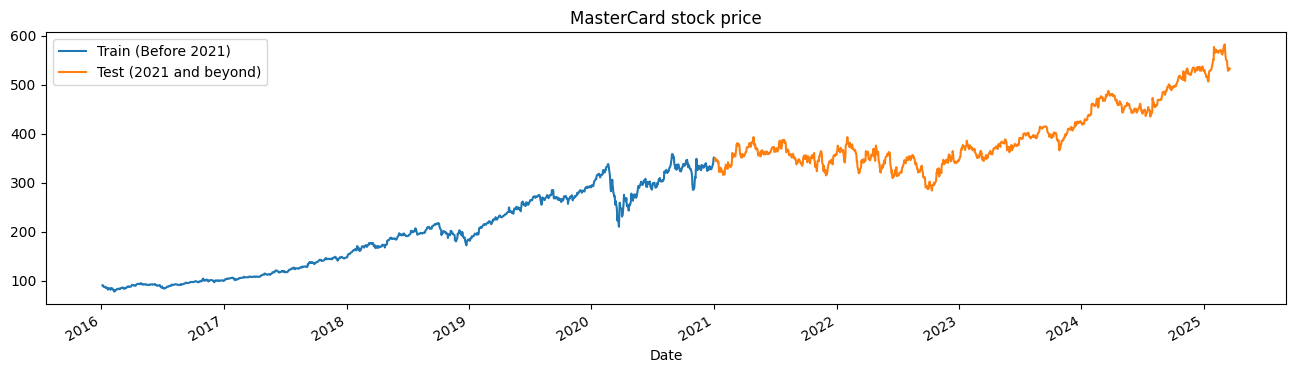

In [55]:
# Forzar índice a datetime con manejo de zona horaria
dataset.index = pd.to_datetime(dataset.index, utc=True).tz_localize(None)

tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)

    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset, tstart, tend)


In [56]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

In [57]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)


In [58]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)


In [59]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)


In [60]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0457
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0032
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0019
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0015
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0012
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0011
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 9.7092e-04
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 8.2683e-04
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 7.6350e-04
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 7.0079e-04


In [62]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [63]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


In [64]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


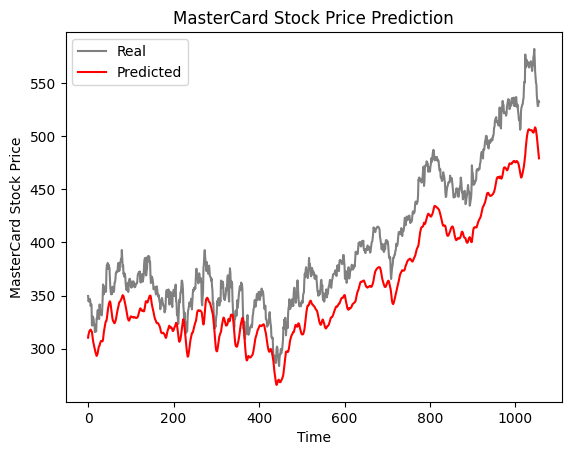

In [65]:
plot_predictions(test_set,predicted_stock_price)


In [66]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 38.84.


In [67]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 125)            │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model_gru.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0615
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0021
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0011
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 9.8486e-04
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 8.7787e-04
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 7.2873e-04
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.1454e-04
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6.1427e-04
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 6.5799e-04
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 5.6205e-04


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


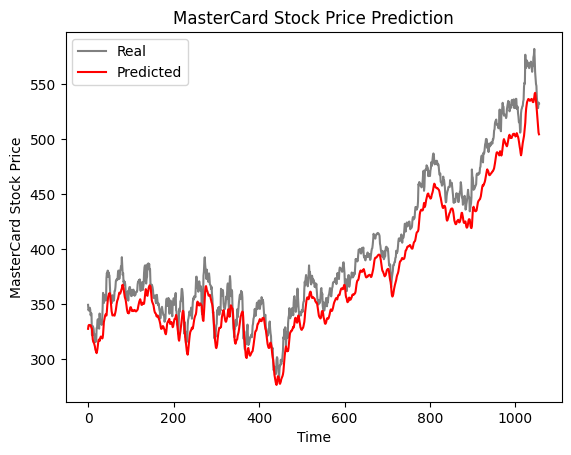

In [69]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)


In [70]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 20.86.
